# Project Description

I'm working with the [dataset](https://www.kaggle.com/datasets/sayankr007/cyber-bullying-data-for-multi-label-classification/data?select=final_hateXplain.csv) from Kaggle which contains annotated social media comments specifically curated for the analysis and detection of cyberbullying. 

The data is labeled across multiple categories including race, religion, gender, sexual orientation, and miscellaneous attributes. Each comment has been carefully reviewed and annotated by multiple annotators to ensure accuracy and reliability.

My goal is to train NLP models which would be able to successfully detect comments which consist of hatespeech and offensive language. My north star is F1 Metric 0.8.

### The To-Do List

**Step 1. Data Loading**

We will load the dataframe with the data, and examine its structure and quality.

**Step 2. Data Preprocessing and Preparation**

We will study the data and, if necessary, perform preprocessing. In addition, we will tokenize and lemmatize the texts.

**Step 3. Model Training**

We will train a logistic regression model, CatBoostRegressor, and Naive Bayes, and evaluate their performance using the F1 metric. If necessary, we will select an additional metric.

**Step 4. Selecting the Best Model**

Considering the Client's requirements, we will select the model that best suits the task.

**Step 5. Project Conclusions**

We will summarize the intermediate results and then provide general conclusions for the entire project.

### Step 1. Data Loading

In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from tqdm import notebook
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

from sklearn.model_selection import (cross_val_score, 
                                     train_test_split, KFold, 
                                     cross_val_predict, GridSearchCV, 
                                     RandomizedSearchCV, TimeSeriesSplit)
from sklearn.feature_extraction.text import TfidfVectorizer 
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.utils import parallel_backend, resample

from IPython.core.display import display, HTML

/tmp/ipykernel_30/3669877077.py:29: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [35]:
TEST_SIZE=0.2
RANDOM_STATE=42

In [36]:
import spacy
import nltk

nltk.download('wordnet')  
nltk.download('omw-1.4')
nltk.download('stopwords') 
nltk.download('punkt') 
nltk.download('averaged_perceptron_tagger') 

from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from urllib.request import urlretrieve
import ssl
# Отключение проверки SSL-сертификатов для загрузки данных NLTK
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Let's look at the shape of our dataset:

In [37]:
df = pd.read_csv('/kaggle/input/cyber-bullying-data-for-multi-label-classification/final_hateXplain.csv')
print('Full train dataset shape is {}'.format(df.shape))

Full train dataset shape is (20109, 7)


In [38]:
df.head(3)

,comment,label,Race,Religion,Gender,Sexual Orientation,Miscellaneous
0,0 u0 lmao wow fuck you too 😂 😂,normal,No_race,Nonreligious,No_gender,No_orientation,NaN
1,1 0 th floor maybe wow cnn with the fakenews t...,offensive,No_race,Nonreligious,No_gender,No_orientation,Other
2,1 0 yrs <number> white women raped by niggers ...,hatespeech,African,Nonreligious,No_gender,No_orientation,NaN


So we have 20109 lines and 6 columns: comment body, label, Race, Religion, Gender, Sexual Orientation, Miscellaneous. Are there any blanks or duplicates?

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20109 entries, 0 to 20108
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   comment             20109 non-null  object
 1   label               20109 non-null  object
 2   Race                20109 non-null  object
 3   Religion            20109 non-null  object
 4   Gender              20109 non-null  object
 5   Sexual Orientation  20109 non-null  object
 6   Miscellaneous       3533 non-null   object
dtypes: object(7)
memory usage: 1.1+ MB


In [40]:
print('The number of duplicates: {}'.format(df.duplicated().sum()))

The number of duplicates: 0


We don't see any blanks or duplicates. Let's see how many normal comments and comments with hatespeech or offensive language:

In [41]:
display(df['label'].value_counts())

tox_ratio = df['label'].value_counts()['normal'] / (df['label']
                                                    .value_counts()['hatespeech'] + df['label']
                                                    .value_counts()['offensive'])

tox_ratio

label
normal        7818
hatespeech    6484
offensive     5807
Name: count, dtype: int64

0.6360751769587503

We can see that the ratio is quite balanced.

## Step 2. Data Preprocessing and Preparation

We will use a common tool for lemmatization, WordNetLemmatizer from nltk, and for tokenization, word_tokenize: they are suitable for most tasks and work with English as well.

In [42]:
slang_dict = {
    'lmao': 'laughing my ass off',
    'k': 'okay',
    'y': 'why',
    'andme': 'and me',
    'ftsomething': 'face time something', 
    'fkcn': 'fucking',
    '1 st': 'first',
    'init': 'is not it',
    'comp': 'compensation',
    'arr': 'arrive',
    'studs': 'students',
    'tho': 'though'
}

In [43]:
nlp = spacy.load('en_core_web_sm')

def replace_slang(word):
    return slang_dict.get(word, word)  # slang_dict — ваш словарь сленгов

def clean_text_spacy(text):
    doc = nlp(replace_slang(text))
    
    lemmatized_output = ' '.join([token.lemma_ for token in doc if token.is_alpha and not token.is_stop and len(token) > 1])
    
    return lemmatized_output

df['lemm_text'] = df['comment'].apply(clean_text_spacy)

df.head(20)

,comment,label,Race,Religion,Gender,Sexual Orientation,Miscellaneous,lemm_text
0,0 u0 lmao wow fuck you too 😂 😂,normal,No_race,Nonreligious,No_gender,No_orientation,NaN,lmao wow fuck
1,1 0 th floor maybe wow cnn with the fakenews t...,offensive,No_race,Nonreligious,No_gender,No_orientation,Other,th floor maybe wow cnn fakenew body count go w...
2,1 0 yrs <number> white women raped by niggers ...,hatespeech,African,Nonreligious,No_gender,No_orientation,NaN,yr number white woman rape nigger number negre...
3,1 2 h ago ching chong accepted your friend req...,offensive,Asian,Nonreligious,No_gender,No_orientation,NaN,ago ching chong accept friend request
4,1 8 th century mayhem and lawlessness had noth...,normal,No_race,Nonreligious,No_gender,No_orientation,NaN,th century mayhem lawlessness loud mouthed don...
5,1 9 3 0 sgermany geneticjews controlled white ...,hatespeech,Caucasian,Jewish,No_gender,No_orientation,NaN,sgermany geneticjew control white germany viol...
6,1 9 5 0 white america the most peaceful decade...,hatespeech,African,Nonreligious,No_gender,No_orientation,NaN,white america peaceful decade usa history numb...
7,1 h de retard au work shessh,normal,No_race,Nonreligious,No_gender,No_orientation,NaN,de retard au work shessh
8,1 st wave feminism let us vote and shit asshol...,normal,No_race,Nonreligious,Women,No_orientation,NaN,st wave feminism let vote shit asshole modern ...
9,2 3 andme is a strange choice for this sort of...,hatespeech,No_race,Jewish,No_gender,No_orientation,NaN,andme strange choice sort thing give primarily...


In [44]:
total_rows = len(df)
lemmatized_rows = df['lemm_text'].notna().sum()

print(f'Lines total: {total_rows}')
print(f'Lemmatized and tokenized lines: {lemmatized_rows}')

Lines total: 20109
Lemmatized and tokenized lines: 20109


Next, we will split the dataset into training and test sets. I won’t create a separate validation set, as we will use parameters from cross-validation for intermediate evaluation.

In [45]:
target = df['label']
features = df.drop(['label'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

print('Shape X_train:', X_train.shape)
print('Shape X_test:', X_test.shape)
print('Shape y_train:', y_train.shape)
print('Shape y_test:', y_test.shape)

Shape X_train: (16087, 7)
Shape X_test: (4022, 7)
Shape y_train: (16087,)
Shape y_test: (4022,)


## Model Training

In this project, we will use cross-validation, and for parameter tuning, we will apply grid search with GridSearchCV. We will use the F1 score as the primary metric and add ROC AUC to assess how well the models distinguish between classes overall. 

Before that, we will define conditions that are the same for all models: the number of folds and evaluation metrics.

In [46]:
df.head(1)

,comment,label,Race,Religion,Gender,Sexual Orientation,Miscellaneous,lemm_text
0,0 u0 lmao wow fuck you too 😂 😂,normal,No_race,Nonreligious,No_gender,No_orientation,NaN,lmao wow fuck


In [47]:
cv_counts = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

scoring = {
    'F1': make_scorer(f1_score, average='weighted'),
    'ROC AUC': make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr') 
}

In [48]:
tfidf_vectorizer = TfidfVectorizer(max_features = 10000, ngram_range=(1,2))

categorical_columns = ['Race', 'Religion', 'Gender', 'Sexual Orientation', 'Miscellaneous']

preprocessor = ColumnTransformer(
    transformers=[
        ('text', tfidf_vectorizer, 'lemm_text'), 
        ('cat', OneHotEncoder(), categorical_columns)
    ]
)

label_encoder = LabelEncoder()

X_train_encoded = preprocessor.fit_transform(X_train)
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
X_test_encoded = preprocessor.transform(X_test)

In [49]:
model_1 = LogisticRegression(max_iter=2000, 
                             class_weight={0: 1, 1: 2, 2: 2}, random_state=RANDOM_STATE)

hyperparams = {
    'C': [0.5, 0.8, 1.0],
    'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg'],
    'multi_class': ['ovr', 'auto']
}

gsearch_1 = RandomizedSearchCV(
    estimator=model_1,
    param_distributions=hyperparams,
    scoring=scoring,
    refit='F1',
    cv=cv_counts,
    verbose=1,
    n_jobs=-1
)

gsearch_1.fit(X_train_encoded, y_train_encoded)

best_params_model_1 = gsearch_1.best_params_
best_model_1_f1 = gsearch_1.best_score_
best_model_1_roc_auc = gsearch_1.cv_results_['mean_test_ROC AUC'][gsearch_1.best_index_]

print(f'Best Params: {best_params_model_1}')
print(f'Best F1 for cross val: {round(best_model_1_f1, 2)}')
print(f'ROC AUC Best Params: {round(best_model_1_roc_auc, 2)}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Params: {'solver': 'saga', 'multi_class': 'auto', 'C': 0.5}
Best F1 for cross val: 0.71
ROC AUC Best Params: 0.87


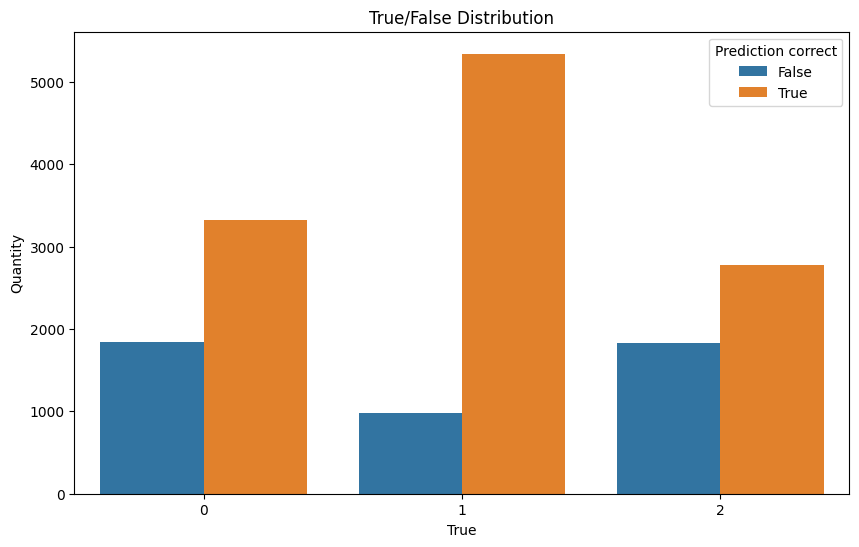

In [50]:
best_model_1 = gsearch_1.best_estimator_

y_pred_cv = cross_val_predict(best_model_1, 
                              X_train_encoded, 
                              y_train_encoded, 
                              cv=cv_counts, 
                              method='predict')

errors_df_logreg = pd.DataFrame({
    'True': y_train_encoded,
    'Predicted': y_pred_cv,
    'Correct': y_train_encoded == y_pred_cv
})

plt.figure(figsize=(10, 6))
sns.countplot(x='True', hue='Correct', data=errors_df_logreg)
plt.title('True/False Distribution')
plt.xlabel('True')
plt.ylabel('Quantity')
plt.legend(title='Prediction correct')
plt.show()

In [51]:
model_2 = RandomForestClassifier(class_weight={0: 1, 1: 1, 2: 2}, random_state=RANDOM_STATE)
hyperparams = {
    'n_estimators': [10, 100, 150],
    'max_depth': [100, 200],
    'min_samples_split': [10, 20],
    'criterion': ['entropy']
}

gsearch_2 = RandomizedSearchCV(
    estimator=model_2, 
    param_distributions=hyperparams,
    scoring=scoring,
    refit='F1',
    cv=cv_counts, 
    verbose=1,
    n_jobs=-1
)

gsearch_2.fit(X_train_encoded, y_train_encoded)

best_params_model_2 = gsearch_2.best_params_
best_model_2_f1 = gsearch_2.best_score_
best_model_2_roc_auc = gsearch_2.cv_results_['mean_test_ROC AUC'][gsearch_2.best_index_]

print(f'Best Params: {best_params_model_2}')
print(f'Best F1 for cross val: {round(best_model_2_f1, 2)}')
print(f'ROC AUC Best Params: {round(best_model_2_roc_auc, 2)}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Params: {'n_estimators': 150, 'min_samples_split': 10, 'max_depth': 100, 'criterion': 'entropy'}
Best F1 for cross val: 0.74
ROC AUC Best Params: 0.89


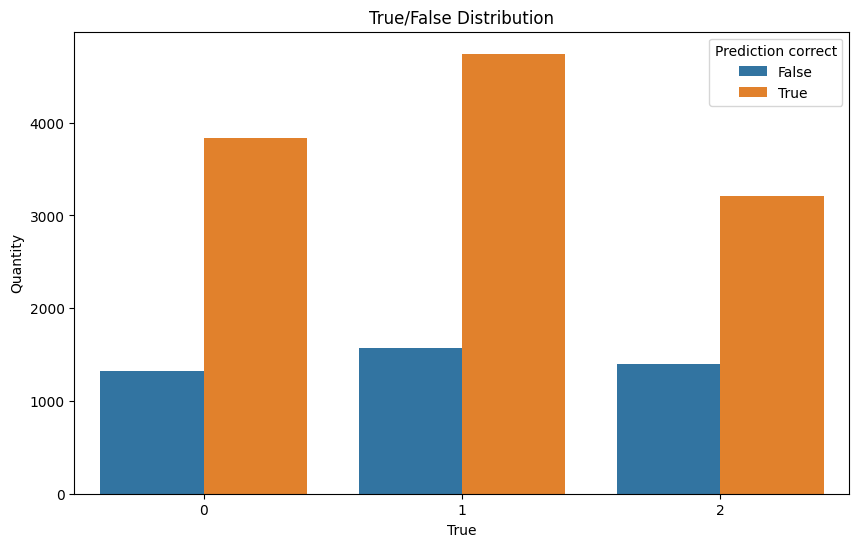

In [52]:
best_model_2 = gsearch_2.best_estimator_

y_pred_cv = cross_val_predict(best_model_2, 
                              X_train_encoded, 
                              y_train_encoded, 
                              cv=cv_counts, 
                              method='predict')

errors_df_logreg = pd.DataFrame({
    'True': y_train_encoded,
    'Predicted': y_pred_cv,
    'Correct': y_train_encoded == y_pred_cv
})

plt.figure(figsize=(10, 6))
sns.countplot(x='True', hue='Correct', data=errors_df_logreg)
plt.title('True/False Distribution')
plt.xlabel('True')
plt.ylabel('Quantity')
plt.legend(title='Prediction correct')
plt.show()

In [54]:
model_lgb = lgb.LGBMClassifier(class_weight={0: 1, 1: 1, 2: 2}, 
                               random_state=RANDOM_STATE,
                              force_col_wise=True,
                              verbose=-1)

param_grid = {
    'n_estimators': [200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'num_leaves': [31, 50, 100],
    'max_depth': [10, 20, 30, -1],
    'min_data_in_leaf': [20, 30, 50]
}

gsearch_lgb = RandomizedSearchCV(
    estimator=model_lgb,
    param_distributions=param_grid,
    scoring=scoring,
    refit='F1', 
    cv=cv_counts, 
    verbose=1,
    n_jobs=-1,
)

gsearch_lgb.fit(X_train_encoded, y_train_encoded)

best_params_lgb = gsearch_lgb.best_params_
best_model_lgb_f1 = gsearch_lgb.best_score_
best_model_lgb_roc_auc = gsearch_lgb.cv_results_['mean_test_ROC AUC'][gsearch_lgb.best_index_]

print(f'Best Params: {best_params_lgb}')
print(f'Best F1 for cross val: {round(best_model_lgb_f1, 2)}')
print(f'ROC AUC Best Params {round(best_model_lgb_roc_auc, 2)}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Params: {'num_leaves': 100, 'n_estimators': 300, 'min_data_in_leaf': 50, 'max_depth': 20, 'learning_rate': 0.05}
Best F1 for cross val: 0.73
ROC AUC Best Params 0.88


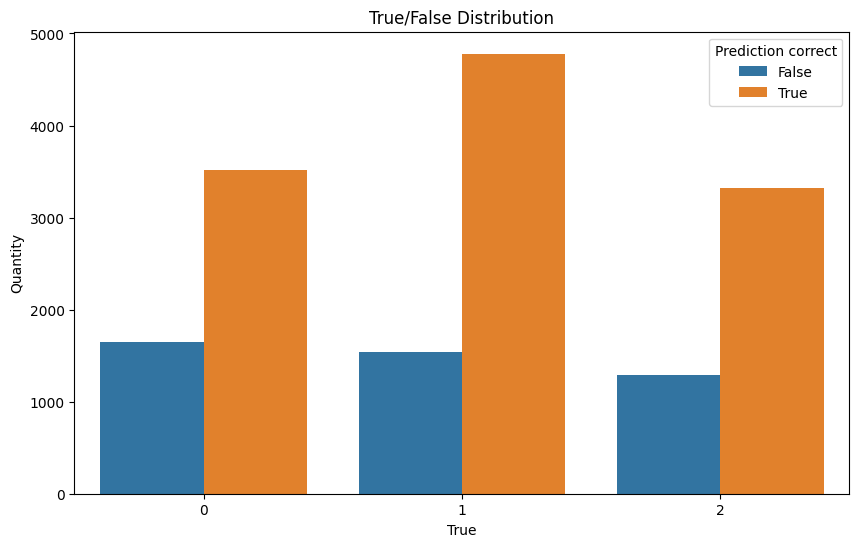

In [55]:
best_model_3 = gsearch_lgb.best_estimator_

y_pred_cv = cross_val_predict(best_model_3, 
                              X_train_encoded, 
                              y_train_encoded, 
                              cv=cv_counts, 
                              method='predict')

errors_df_logreg = pd.DataFrame({
    'True': y_train_encoded,
    'Predicted': y_pred_cv,
    'Correct': y_train_encoded == y_pred_cv
})

plt.figure(figsize=(10, 6))
sns.countplot(x='True', hue='Correct', data=errors_df_logreg)
plt.title('True/False Distribution')
plt.xlabel('True')
plt.ylabel('Quantity')
plt.legend(title='Prediction correct')
plt.show()

In [57]:
best_model_2 = gsearch_2.best_estimator_
y_pred = best_model_2.predict(X_test_encoded)
accuracy = round(accuracy_score(y_test_encoded, y_pred), 4) * 100

conf_matrix = confusion_matrix(y_test_encoded, y_pred)
classification_rep = classification_report(y_test_encoded, y_pred)

print(f'Accuracy: {accuracy}%')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 72.23%
Confusion Matrix:
[[ 958   31  336]
 [  38 1118  346]
 [ 225  141  829]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.72      0.75      1325
           1       0.87      0.74      0.80      1502
           2       0.55      0.69      0.61      1195

    accuracy                           0.72      4022
   macro avg       0.73      0.72      0.72      4022
weighted avg       0.75      0.72      0.73      4022

